In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
@jax.tree_util.Partial(jax.jit, static_argnums=(2, 3, 4, 5, 6))
def update_views(i, view_mat, alpha, n_agents, n_considered, extreme_bias, dist_ord):
    I = get_ingroup(i, key, view_mat, n_agents, n_considered, extreme_bias, dist_ord)
    O = get_outgroup(i, key, view_mat, n_agents, n_considered, extreme_bias, dist_ord)
    own_views = view_mat[i]
    ingroup_views = view_mat[I]
    outgroup_views = view_mat[O]
    
    return own_views + ((jnp.mean(ingroup_views, axis=0) - own_views) / 4) - alpha * ((jnp.mean(outgroup_views, axis=0) - own_views) / 4)


@jax.jit
def normalize(x):
    return x / jnp.sum(x)


@jax.tree_util.Partial(jax.jit, static_argnums=(3,))
def get_distance(i, j, view_mat, dist_ord):
    return jnp.linalg.norm(view_mat[i] - view_mat[j], ord=dist_ord)


@jax.tree_util.Partial(jax.jit, static_argnums=(2, 3))
def get_distances(i, view_mat, n_agents, dist_ord):
    return jax.vmap(get_distance, in_axes=(None, 0, None, None))(i, jnp.arange(n_agents), view_mat, dist_ord)


@jax.jit
def get_norms(view_mat):
    return jax.vmap(lambda x: jnp.linalg.norm(x, ord=2))(view_mat)


@jax.tree_util.Partial(jax.jit, static_argnums=(3, 4, 5, 6))
def get_ingroup(i, key, view_mat, n_agents, n_considered, extreme_bias, dist_ord):
    d = get_distances(i, view_mat, n_agents, dist_ord)
    norms = get_norms(view_mat)
    prob = 1/(jnp.power(d, 1.) + 1e-10) * jnp.power(norms, extreme_bias)
    prob = normalize(prob.at[i].set(0))
    return jax.random.choice(key, jnp.arange(n_agents), shape=(n_considered,), p=prob, replace=False)


@jax.tree_util.Partial(jax.jit, static_argnums=(3, 4, 5, 6))
def get_outgroup(i, key, view_mat, n_agents, n_considered, extreme_bias, dist_ord):
    d = get_distances(i, view_mat, n_agents, dist_ord)
    norms = get_norms(view_mat)
    prob = jnp.power(d, 2.) * jnp.power(norms, extreme_bias)
    prob = normalize(prob.at[i].set(0))
    return jax.random.choice(key, jnp.arange(n_agents), shape=(n_considered,), p=prob, replace=False)


def randomize(view_mat, n_replace):
    indicies = np.random.randint(1, 100000, (n_replace,))
    key = jax.random.PRNGKey(np.random.randint(1, 100000))
    view_mat = view_mat.at[indicies].set(jax.random.normal(key, (n_replace, n_views)))
    return view_mat


def iterate(view_mat, i, alpha, n_iter, n_agents, n_considered, n_replace, n_views, extreme_bias, dist_ord):
    for k in range(n_iter):
        keys = jnp.array([jax.random.PRNGKey(i) for i in np.random.randint(1, 1000000, (n_agents,))])
        if n_replace:
            view_mat = randomize(jnp.squeeze(jax.vmap(update_views, in_axes=(0, None, None, None, None, None, None))(jnp.arange(n_agents), view_mat, alpha, n_agents, n_considered, extreme_bias, dist_ord)), n_replace)
        else:
            view_mat = jnp.squeeze(jax.vmap(update_views, in_axes=(0, None, None, None, None, None, None))(jnp.arange(n_agents), view_mat, alpha, n_agents, n_considered, extreme_bias, dist_ord))
        
        
    fig = pd.plotting.scatter_matrix(pd.DataFrame(view_mat), figsize=(16, 16))
    plt.savefig(f'./latex/images/{n_agents}_{n_considered}_{n_replace}_{n_views}_{i+n_iter}.png')

    print(f'Norm of diff between current and inital median views {jnp.linalg.norm(jnp.median(init_view_mat, axis=0) - jnp.median(view_mat, axis=0), ord=2)}')
    
    return view_mat, i + n_iter

In [3]:
key = jax.random.PRNGKey(np.random.randint(1, 100000))
n_agents = 200
n_considered = 10
n_replace = 0
# n_replace = n_agents // 5
n_views = 8
n_iter = 5
extreme_bias = 1.5
dist_ord = 1/2
alpha = 0.2

i = 0
view_mat = jax.random.normal(key, (n_agents, n_views))
init_view_mat = jnp.array(np.copy(view_mat))

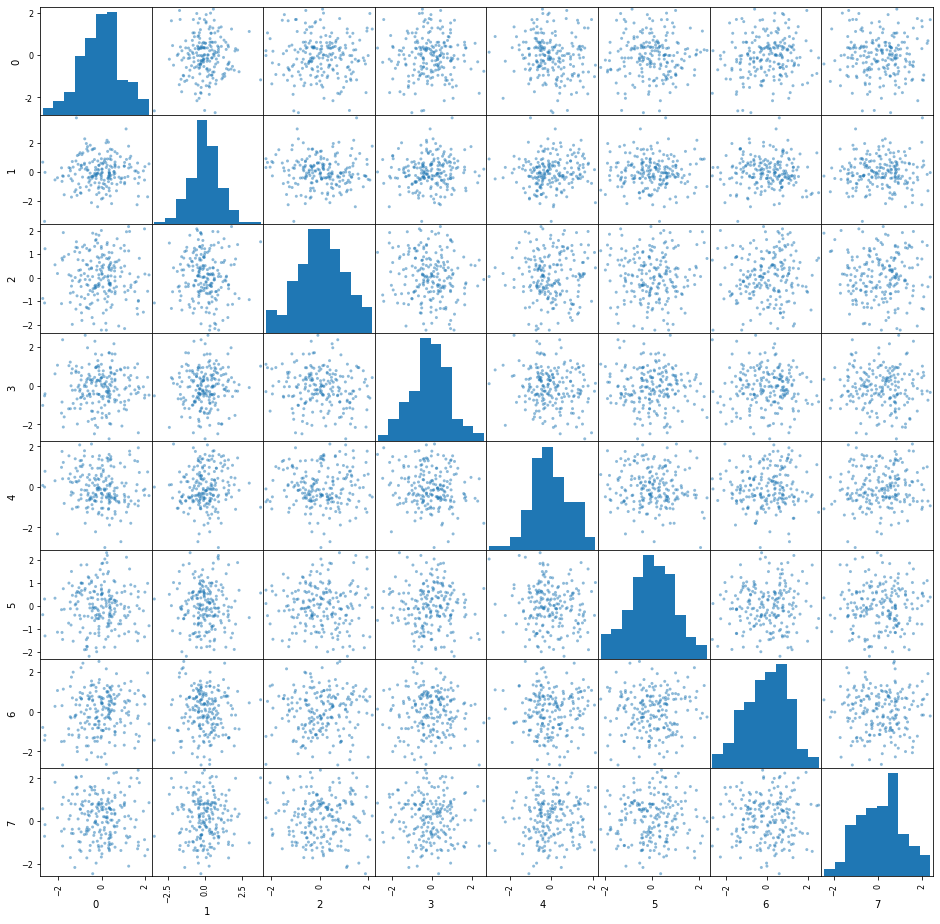

In [4]:
fig = pd.plotting.scatter_matrix(pd.DataFrame(view_mat), figsize=(16, 16))
plt.savefig(f'./latex/images/{n_agents}_{n_considered}_{n_replace}_{n_views}_{i}.png')

Norm of diff between current and inital median views 0.48473718762397766


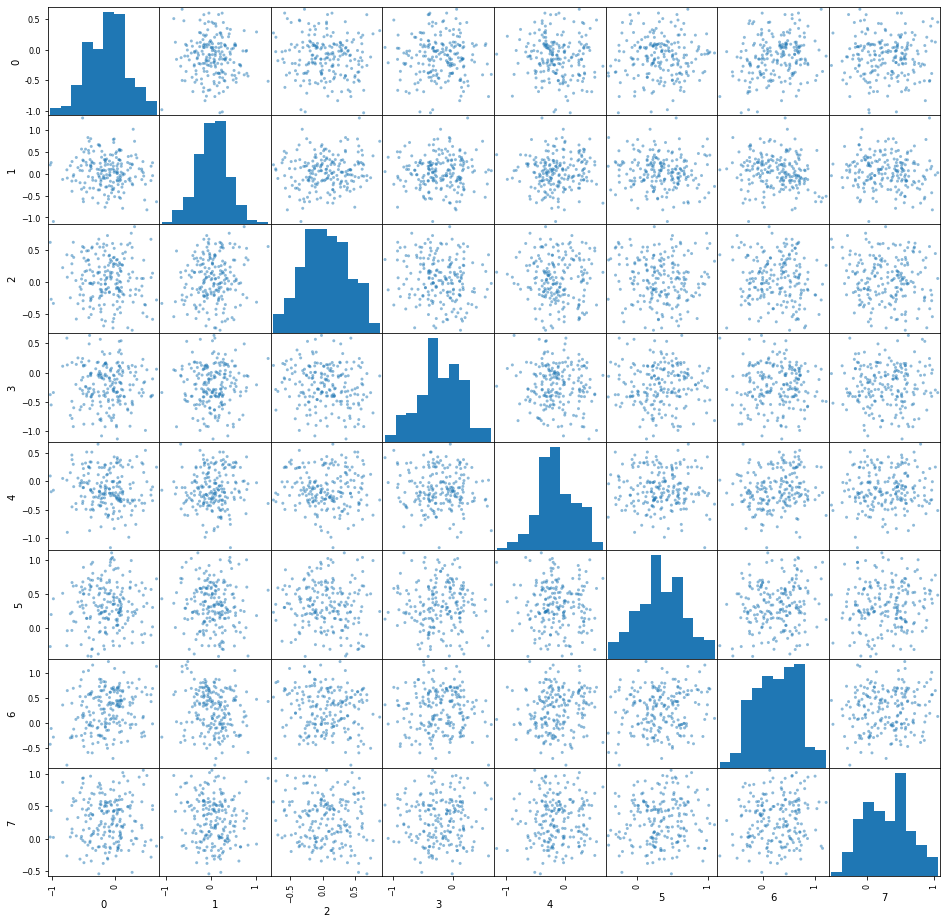

In [5]:
view_mat, i = iterate(view_mat, i, alpha, n_iter, n_agents, n_considered, n_replace, n_views, extreme_bias, dist_ord)

Norm of diff between current and inital median views 0.6199663281440735


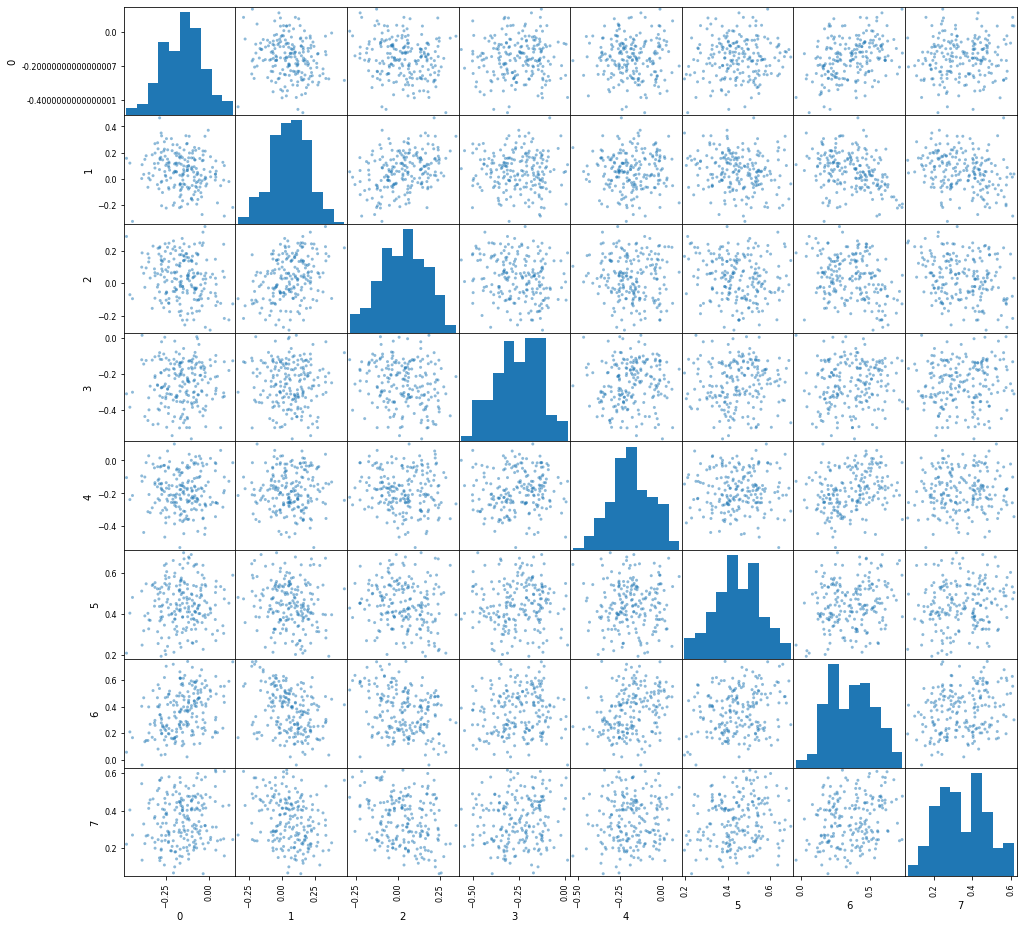

In [6]:
view_mat, i = iterate(view_mat, i, alpha, n_iter, n_agents, n_considered, n_replace, n_views, extreme_bias, dist_ord)

Norm of diff between current and inital median views 0.6717945337295532


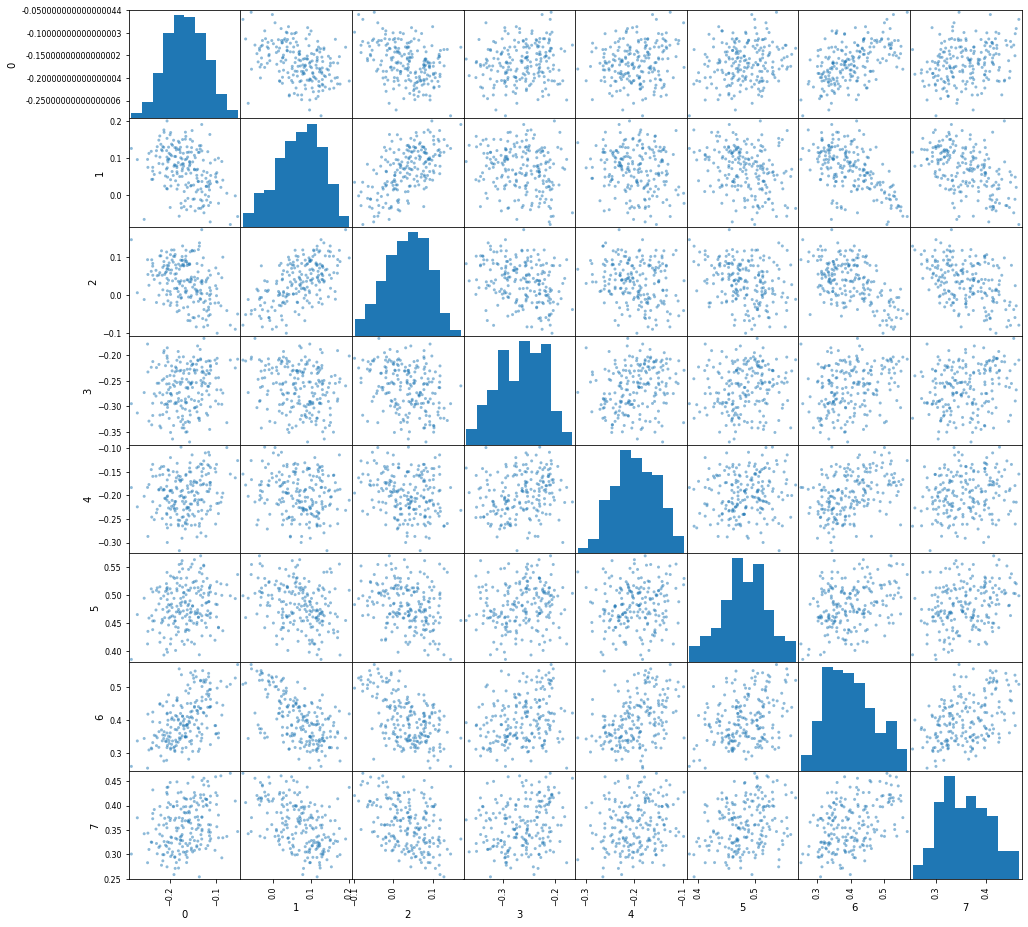

In [7]:
view_mat, i = iterate(view_mat, i, alpha, n_iter, n_agents, n_considered, n_replace, n_views, extreme_bias, dist_ord)

Norm of diff between current and inital median views 0.6911664605140686


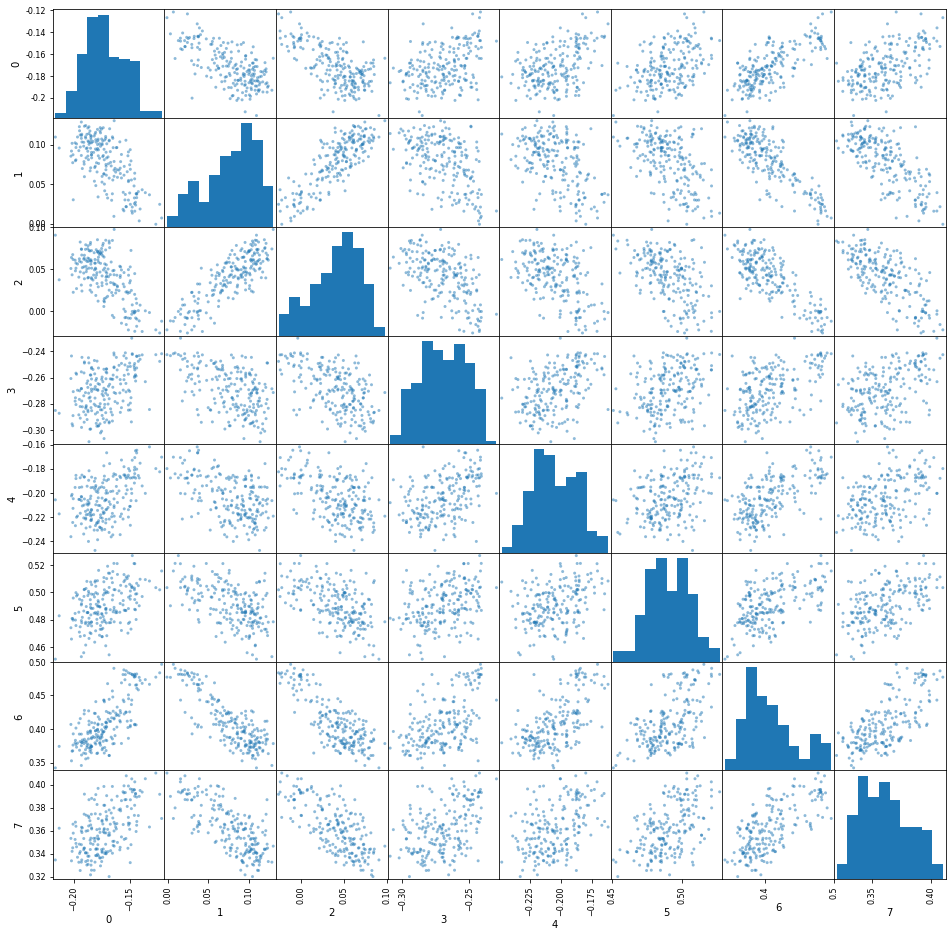

In [8]:
view_mat, i = iterate(view_mat, i, alpha, n_iter, n_agents, n_considered, n_replace, n_views, extreme_bias, dist_ord)

Norm of diff between current and inital median views 0.6930184364318848


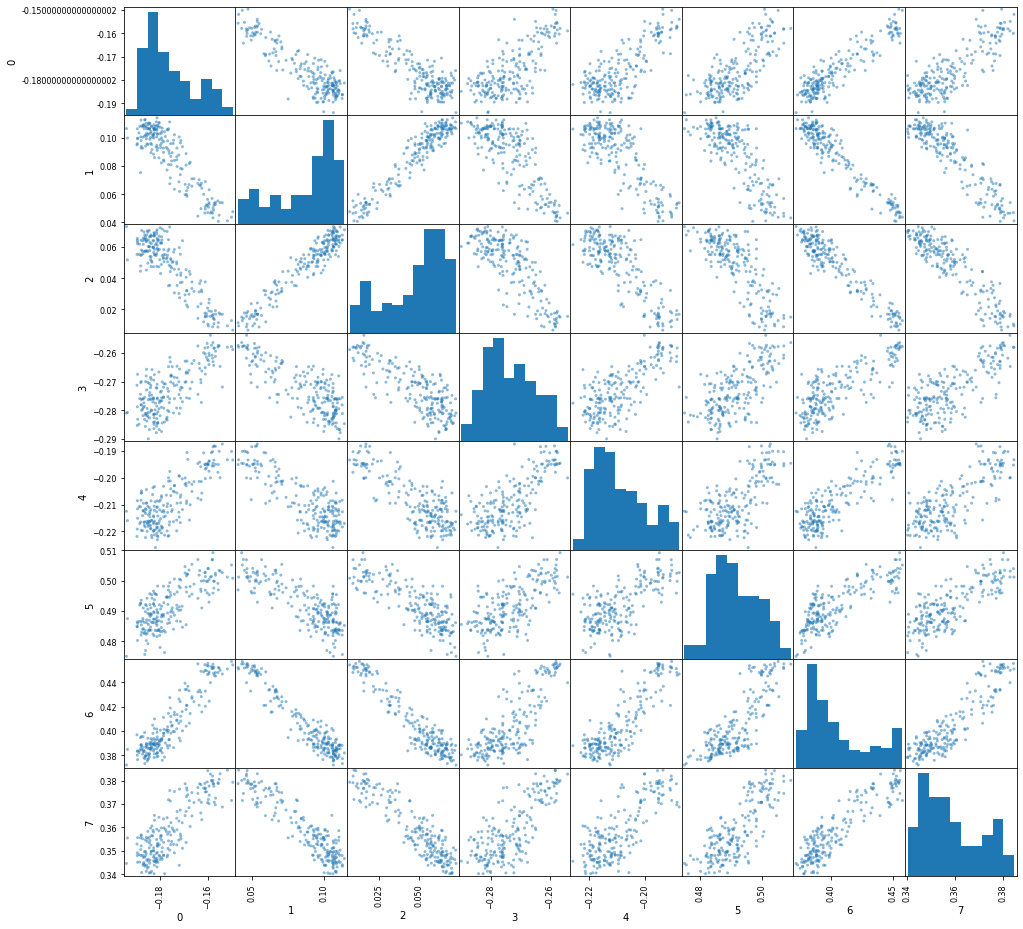

In [9]:
view_mat, i = iterate(view_mat, i, alpha, n_iter, n_agents, n_considered, n_replace, n_views, extreme_bias, dist_ord)

Norm of diff between current and inital median views 0.6910564303398132


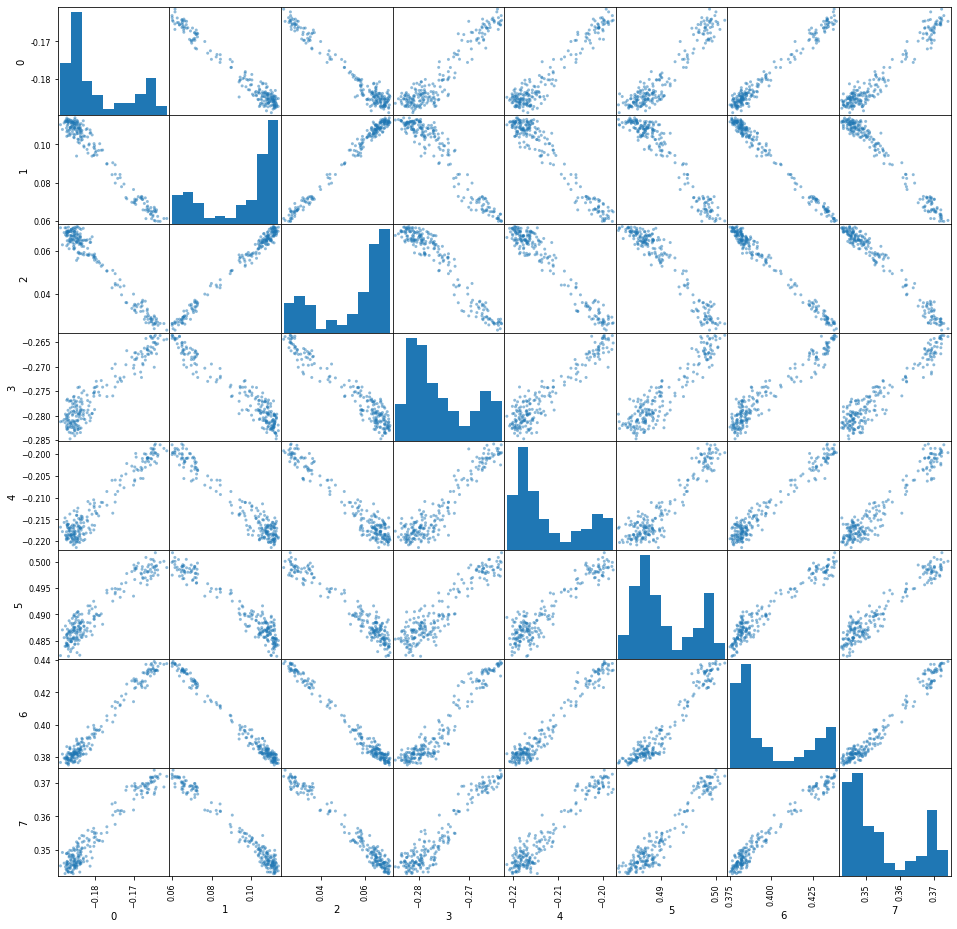

In [10]:
view_mat, i = iterate(view_mat, i, alpha, n_iter, n_agents, n_considered, n_replace, n_views, extreme_bias, dist_ord)

Norm of diff between current and inital median views 46.19190216064453


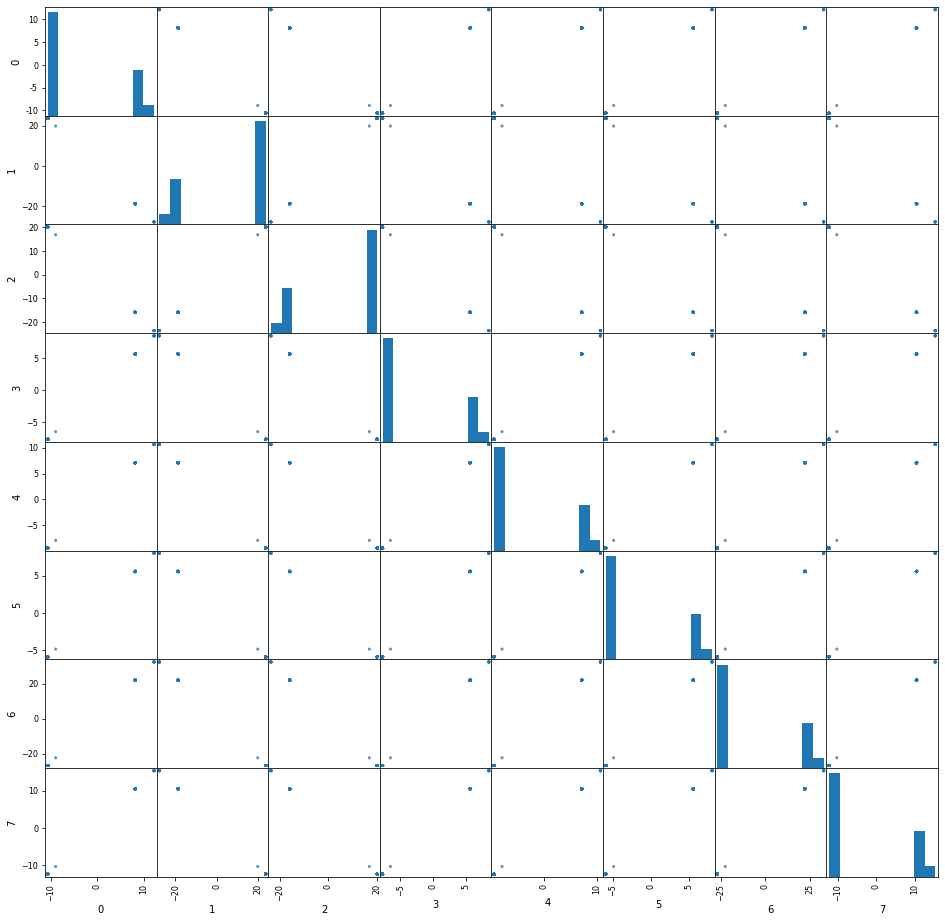

In [11]:
view_mat, i = iterate(view_mat, i, alpha, 100, n_agents, n_considered, n_replace, n_views, extreme_bias, dist_ord)